Get data

In [463]:
file_path = "./data/X.csv"
X = pd.read_csv(file_path)

file_path = "./data/y.csv"
y = pd.read_csv(file_path)


In [464]:
df_org = X.join(y.set_index('id'))

df_mod = df_org

df_mod.set_index('id',inplace= True)

# clear all null lines
for column in df_mod.columns:
    nulls_mask = df_mod[column].notnull()  # or column_with_nulls.isna()
    df_mod = df_mod[nulls_mask]

# drop unnamed columns
df_mod.drop(columns='Unnamed: 0', inplace=True)
df_mod.drop(columns='Unnamed: 0.1',inplace=True)

# removing data point with Gender = 'O'
df_mod = df_mod[df_mod['Gender']!='O']

# setting 'id' column as index
# df_mod.set_index('id', inplace = True)

# deal with categorial columns

label_encoder = LabelEncoder()
for column in df_mod.select_dtypes(include=['object']).columns:
    df_mod[column + '_encoded'] = label_encoder.fit_transform(df_mod[column])

# Train test split
X_train, X_test, y_train, y_test =train_test_split(df_mod.drop(columns = 'Salary'), df_mod.Salary, test_size = 0.3, random_state = 42)

# get all relevant column names
categorical_columns = df_mod.select_dtypes(include=['object']).columns.tolist()

# drop_categorial = True
# if (drop_categorial):
#     df_mod = df_mod.drop(columns=categorical_columns)
# else:
#     # drop some of them
#     categorical_columns_remove = 'Job Title'
#     categorical_columns = [item for item in categorical_columns if item != categorical_columns_remove]


#     df_mod = pd.get_dummies(df_mod,columns = categorical_columns)

# df = df_mod

In [465]:
df_mod

,Age,Gender,Education Level,Job Title,Years of Experience,Country,Race,height,weight,professionalism,Salary,Gender_encoded,Education Level_encoded,Job Title_encoded,Country_encoded,Race_encoded
id,,,,,,,,,,,,,,,,
2477,52.0,M,bachelor's|degr,back|end|develope,24.0,australi,Asian,1.800316,95.021957,1150.0,90000.0,1,1,3,0,1
76,52.0,F,bachelor,operations|manage,23.0,us,White,2.451414,87.456039,1100.0,65000.0,0,0,92,4,9
242,39.0,F,bachelor,senior|product|manage,11.0,chin,Korean,1.794105,72.049210,380.0,200000.0,0,0,136,2,6
5544,34.0,F,master's|degr,marketing|manage,11.0,us,White,2.068465,77.713279,297.0,55000.0,0,4,87,4,9
6017,34.0,F,bachelor's|degr,marketing|manage,9.0,u,White,2.118734,54.683693,256.0,120000.0,0,1,87,3,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354,32.0,F,bachelor,junior|business|development|associat,4.0,canad,Black,2.329507,64.070050,93.0,50000.0,0,0,52,1,3
3677,44.0,M,p,data|scientis,15.0,chin,White,1.945457,93.478548,546.0,120000.0,1,5,19,2,9
6032,25.0,M,high|scho,delivery|drive,1.0,canad,Asian,1.575751,38.216264,0.0,85000.0,1,2,20,1,1


In [466]:
X_train_copy = X_train[['professionalism','Gender_encoded', 'Education Level_encoded', 'Job Title_encoded',
       'Country_encoded', 'Race_encoded']]

In [467]:
# sns.pairplot(df_mod,vars = ['Salary','Gender_encoded', 'Education Level_encoded', 'Job Title_encoded', 'Country_encoded', 'Race_encoded'])



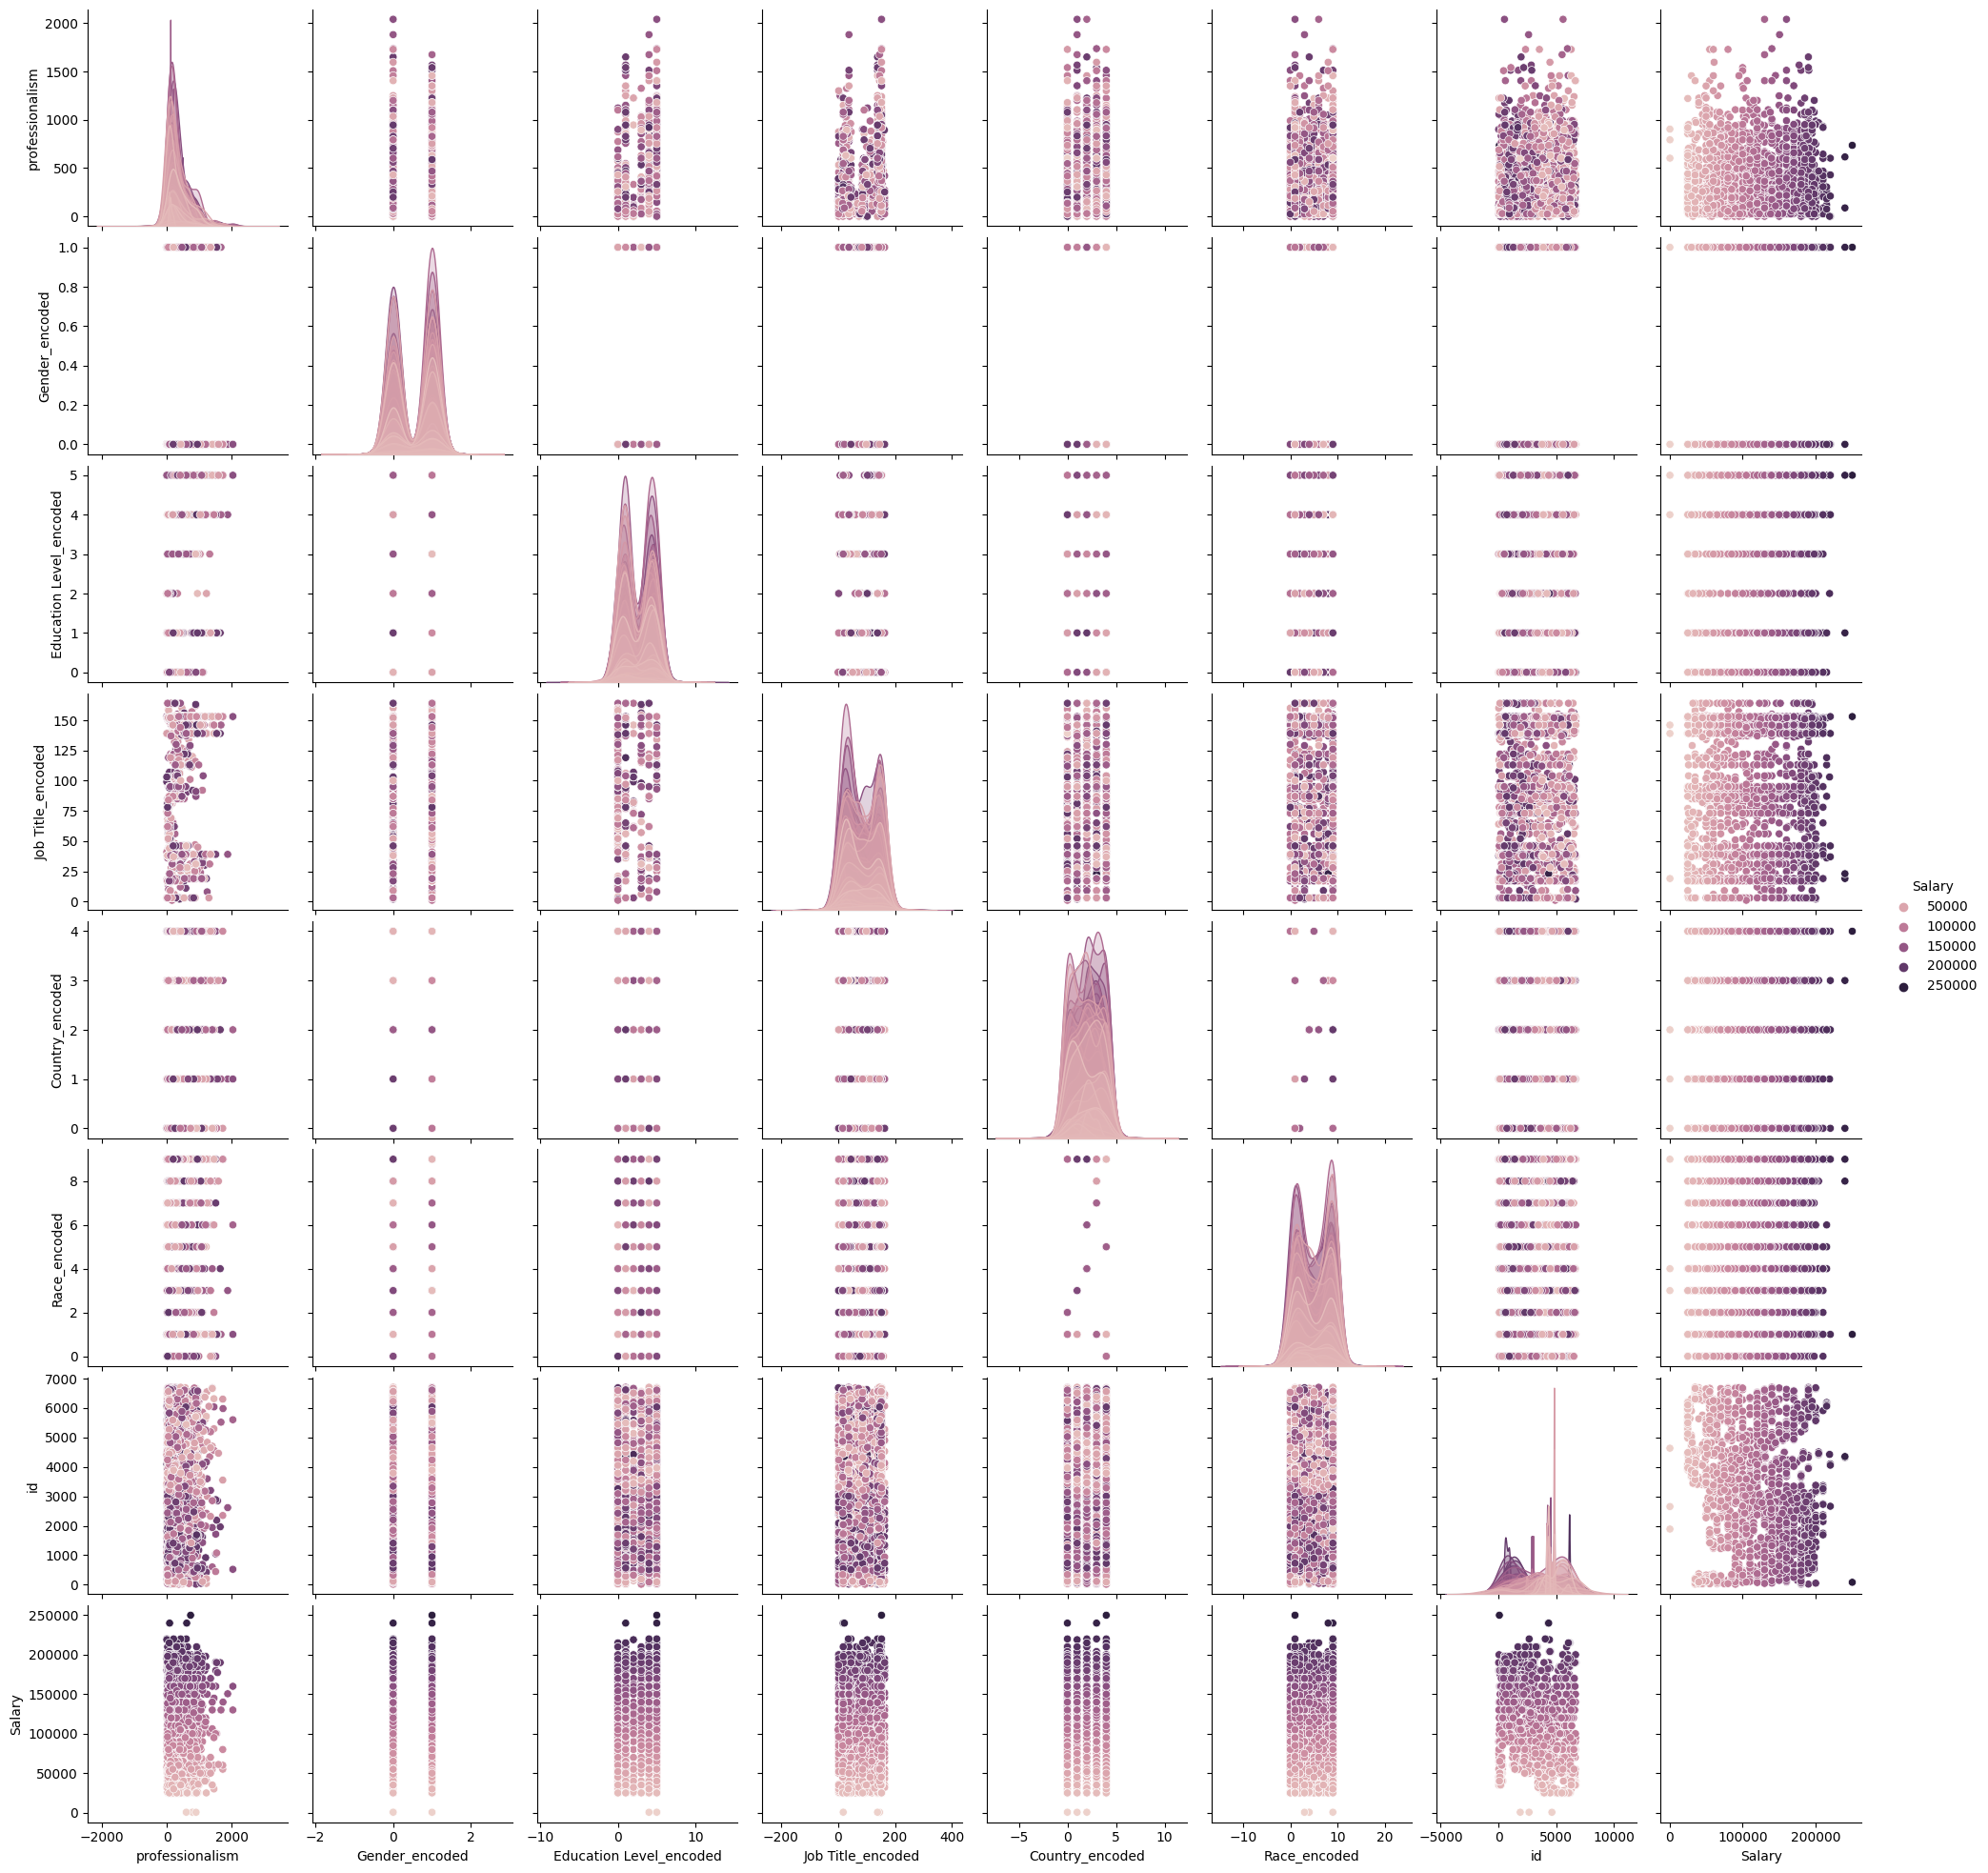

In [468]:
sns.pairplot(X_train_copy.join(y), vars = X_train_copy.join(y).columns, hue = 'Salary')



<Axes: xlabel='Race_encoded', ylabel='Country_encoded'>

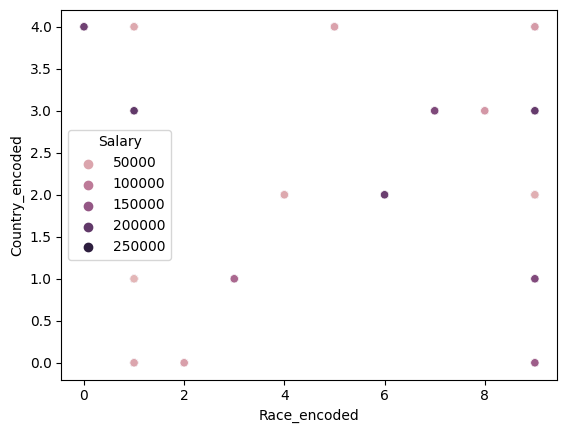

In [469]:
sns.scatterplot(data = X_train.join(y_train),x= 'Race_encoded', y = 'Country_encoded', hue = 'Salary')

In [470]:
# X_and_y = X.join(y.set_index('id'))
# X_and_y.columns.values

In [471]:
# X_and_y.drop(columns = ['Unnamed: 0.1', 'Unnamed: 0'], inplace = True)
# # X_and_y.set_index('id', inplace= True)
# features = list(X_and_y.columns.values)
# features

In [472]:
# X_and_y.columns
# X_and_y.drop(columns = ['Salary','Unnamed: 0.1', 'Unnamed: 0'], inplace = True)
# X_and_y = X_and_y.join(y.set_index('id'))
# X_and_y.columns

In [473]:
# df_mod = df_mod['Age','Gender_encoded','Education Level_encoded','Job Title_encoded','Country_encoded', 'Race_encoded','Salary']

In [474]:
# # X_and_y.groupby(['Country','Age', 'Gender','Education Level'])['Salary'].aggregate('count').sort_values().head(500)

# X = X_and_y.drop(columns = 'Salary')
# y = X_and_y.Salary

In [479]:
from sklearn.metrics import mean_squared_error

# split
# X_train, X_test, y_train, y_test = train_test_split(X_train[['Gender_encoded','Race_encoded']], df_mod.Salary, test_size=0.33, random_state=42)

# define alphas to interate through
alphas = [0.001, 0.01, 0.1,1, 10,100, 1000,10000]

from sklearn.linear_model import LinearRegression, Lasso, Ridge

for alpha in alphas:
  # print(alpha)
  # instantiate class object
  lasso = Lasso(alpha = alpha)
  ridge = Ridge(alpha = alpha)

  # fit
  lasso.fit(X_train[['Country_encoded','Race_encoded']], y_train)
  ridge.fit(X_train[['Country_encoded','Race_encoded']], y_train)

  # predict
  y_pred_lasso = lasso.predict(X_test[['Country_encoded','Race_encoded']])
  y_pred_ridge = ridge.predict(X_test[['Country_encoded','Race_encoded']])

  # score
  lasso_rmse = np.sqrt(mean_squared_error(y_test, y_pred_lasso))
  ridge_rmse = np.sqrt(mean_squared_error(y_test, y_pred_ridge))

  # print coeffiecients
  print(f"lasso rmse is {lasso_rmse:.1f} and ridge rmse is {ridge_rmse:.1f}")
  print(f'for alpha = {alpha}:')
  print(f"and features {X_train[['Country_encoded','Race_encoded']].columns.values}:")
  print(f"lasso coefficients are: {lasso.coef_}")
  print(f"ridge coefficients are: {ridge.coef_}\n")

lasso rmse is 51417.7 and ridge rmse is 51417.7
for alpha = 0.001:
and features ['Country_encoded' 'Race_encoded']:
lasso coefficients are: [-559.07898835  208.77093811]
ridge coefficients are: [-559.07941471  208.77103475]

lasso rmse is 51417.7 and ridge rmse is 51417.7
for alpha = 0.01:
and features ['Country_encoded' 'Race_encoded']:
lasso coefficients are: [-559.07427588  208.76998241]
ridge coefficients are: [-559.07855239  208.77094927]

lasso rmse is 51417.7 and ridge rmse is 51417.7
for alpha = 0.1:
and features ['Country_encoded' 'Race_encoded']:
lasso coefficients are: [-559.02728868  208.76043017]
ridge coefficients are: [-559.06992925  208.77009443]

lasso rmse is 51417.7 and ridge rmse is 51417.7
for alpha = 1:
and features ['Country_encoded' 'Race_encoded']:
lasso coefficients are: [-558.55741673  208.66490773]
ridge coefficients are: [-558.98371241  208.76154683]

lasso rmse is 51417.5 and ridge rmse is 51417.7
for alpha = 10:
and features ['Country_encoded' 'Race_encod

In [ ]:
races = X_train['Race_encoded'].unique()
countries = X_train['Country_encoded'].unique()

# sns.pairplot(X_train_copy.join(y), vars = X_train_copy.join(y).columns, hue = 'Salary')

for race in races:
    for country in countries:
        # sns.pairplot(X_train_copy.join(y.set_index('id')), vars = X_train_copy.join(y.set_index('id').columns[:-4], hue = 'Salary')

In [526]:
groups.unique().size

17

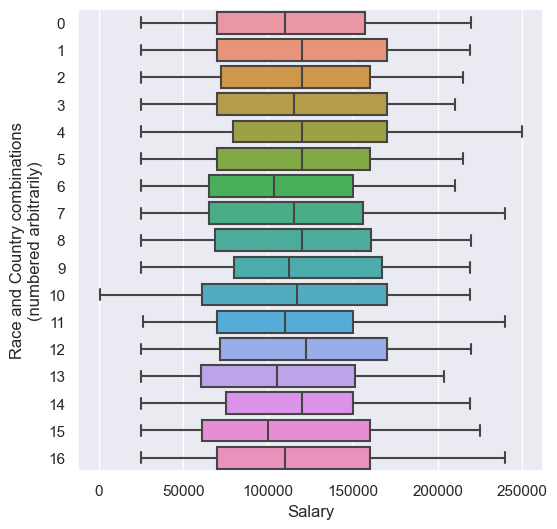

In [564]:
# removing 'Salary' NaN values
data = data[~data['Salary'].isna()]
# grouping by race and country
groups = data.groupby(['Country_encoded', 'Race_encoded']).ngroup()

sns.boxplot(data = data, x = 'Salary', y = groups, orient = 'h').set(ylabel = "Race and Country combinations\n(numbered arbitrarily)")
# setting sns figure size
sns.set(rc={'figure.figsize':(6,6)})

In [582]:
# The following code performs a Kolmogorov-Smirnov test on these two datasets 
# to determine if they came from the same distribution

from scipy.stats import ks_2samp

#perform Kolmogorov-Smirnov test

ks_2samp(groups[groups == 12], groups[groups == 15])[1]

i, j = 0,0
res = []

for i in range(len(groups.unique())):
    for j in range(len(groups.unique())):
        # print(f"i = {i}, j = {j}")
        # print(ks_2samp(groups[groups == i], groups[groups == j])[1],'\n')
        res.append(ks_2samp(groups[groups == i], groups[groups == j])[1])

        # printing the KS test p-value, to assess whetehr most distribs are statistically different. Answer = Yes.
# print(res.sort())

[9.937645711805952e-129,
 9.937645711805952e-129,
 1.501315273425464e-126,
 1.501315273425464e-126,
 1.6045983401340757e-124,
 1.6045983401340757e-124,
 5.4022237530995395e-124,
 5.4022237530995395e-124,
 1.1407741529387858e-123,
 1.1407741529387858e-123,
 1.0917061313553456e-122,
 1.0917061313553456e-122,
 5.048255797914834e-122,
 5.048255797914834e-122,
 1.0480896555061758e-121,
 1.0480896555061758e-121,
 9.529862352643926e-121,
 9.529862352643926e-121,
 5.271107862282667e-120,
 5.271107862282667e-120,
 1.0756270866180869e-119,
 1.0756270866180869e-119,
 1.1121862146997382e-119,
 1.1121862146997382e-119,
 9.284244673097551e-119,
 9.284244673097551e-119,
 8.308325739933583e-118,
 8.308325739933583e-118,
 2.4678872622139973e-117,
 2.4678872622139973e-117,
 6.407918080800151e-117,
 6.407918080800151e-117,
 2.004879515588632e-116,
 2.004879515588632e-116,
 3.237871074399115e-116,
 3.237871074399115e-116,
 3.969050817662771e-116,
 3.969050817662771e-116,
 6.907759402644488e-116,
 6.907759

In [578]:
range(len(groups.unique()))

range(0, 17)

In [546]:
groups[groups == 15]

id
133     15
70      15
2895    15
6512    15
5740    15
        ..
6441    15
2934    15
2748    15
908     15
4102    15
Length: 150, dtype: int64

In [478]:
# My Solution - KNN

# n_neighbors = list(range(2,20))

weights = ['uniform','distance']

leafs = [10, 20, 30, 40, 50]

for weight in weights:
  for leaf in leafs:
    # instantiate class object
    # print(val)
    # print(type(val))
    knr = KNeighborsRegressor(n_neighbors = 5, weights = weight, algorithm = 'ball_tree', leaf_size = leaf)
    
    # fit
    knr.fit(X_train,y_train)
    
    # predict
    y_pred_knn_train = knr.predict(X_train)
    y_pred_knn_test = knr.predict(X_test)
    
    # score
    knr_rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_knn_train))
    knr_rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_knn_test))

    # print coeffiecients
    print(f"When weight equals {weight}:")
    print(f"K-Nearest Neighbour Reg. train model's rmse is {knr_rmse_train:.2f}")
    print(f"K-Nearest Neighbour Reg. test model's rmse is {knr_rmse_test:.2f}")
    print(f"rmse_test - rmse_train = {knr_rmse_test - knr_rmse_train}\n")

ValueError: could not convert string to float: 'M'

In [ ]:
X_train.info()

In [ ]:
# df2 = df_org.drop(columns = ['Unnamed: 0.1','Unnamed: 0'])
# df2.set_index('id', inplace =True)
# df2.columns

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(df2['Job Title'], df2.Salary, test_size=0.33, random_state=42)

In [ ]:

# Decision Tree Regressor - My Solution

min_samples_split = list(range(2,20+1))

for val in min_samples_split:
  # instantiate class object
  dtr = DecisionTreeRegressor(min_samples_split = val)

  # fit
  dtr.fit(X_train, y_train)

  # predict
  y_pred_train_dtr = dtr.predict(X_train)
  y_pred_test_dtr = dtr.predict(X_test)


  # score
  dtr_train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train_dtr))
  dtr_test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test_dtr))
  # print coeffiecients
  print(f"When minimal samples split equals {val}:")
  print(f"Decision Tree reg. training model's rmse is {dtr_train_rmse:.4f}")
  print(f"Decision Tree reg. test model's rmse is {dtr_test_rmse:.4f}")
  print(f"the difference between train's and test's rmse's is {dtr_test_rmse - dtr_train_rmse:.2f}\n")  
  # print(f"and features {X.columns.values}:")
  # print(f"Decision Tree reg. model's coefficients are: {dtr.coef_}\n")